In [1]:
from __future__ import absolute_import, print_function

import argparse, json, os, requests, sys, time
from io import BytesIO
from os.path import join, isfile
from PIL import Image

from mxnet.gluon.model_zoo import vision
import numpy as np
from matplotlib import pyplot as plt

import tvm
from tvm import te
from tvm import rpc, autotvm, relay
from tvm.contrib import graph_runtime, utils, download
from tvm.contrib.debugger import debug_runtime
from tvm.relay import transform

import vta
from vta.testing import simulator
from vta.top import graph_pack

import torch
import torchvision
from tvm.contrib.download import download_testdata

from torch import nn
from torchvision import datasets, transforms


# Make sure that TVM was compiled with RPC=1
assert tvm.runtime.enabled("rpc")

In [2]:
# Load VTA parameters from the 3rdparty/vta-hw/config/vta_config.json file
env = vta.get_env()

# Set ``device=arm_cpu`` to run inference on the CPU
# or ``device=vta`` to run inference on the FPGA.
device = "vta"
target = env.target if device == "vta" else env.target_vta_cpu

# Dictionary lookup for when to start/end bit packing
pack_dict = {
    "resnet18_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet34": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet50": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "resnet101": ["nn.max_pool2d", "nn.adaptive_avg_pool2d"],
    "vgg11": ["nn.max_pool2d", "nn.dense"],
    "vgg16":    ["nn.max_pool2d", "nn.dense"],
    "resnet34_v1": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet18_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet34_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet50_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "resnet101_v2": ["nn.max_pool2d", "nn.global_avg_pool2d"],
    "mobilenetv2_1.0": ["nn.max_pool2d", "nn.global_avg_pool2d"]
}

# Name of Gluon model to compile
# The ``start_pack`` and ``stop_pack`` labels indicate where
# to start and end the graph packing relay pass: in other words
# where to start and finish offloading to VTA.
#model = "resnet18_v1"
#assert model in pack_dict
model = "resnet18"

In [3]:
class Residual(nn.Module):  # @save
    """The Residual block of ResNet."""

    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)

        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):

        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))

        if self.conv3:
            X = self.conv3(X)

        Y += X

        return self.relu(Y)


def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2,
                                ))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk








b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=(7,7), stride=(2,2), padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(inplace=True),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

resnet18_base = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

chkpt_path = f'/mnt/hgfs/vmware_ubuntu_sf/adv_attack_checkpoints/model_checkpoints/resnet18_scratch_imagenette_dual_gpu.pth'
#
# # victim_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
# # # Modify the output layer according to your specific problem (e.g., number of classes)
# # victim_model.fc = nn.Linear(victim_model.fc.in_features, 10)
#
victim_model = resnet18_base
state_dict = torch.load(chkpt_path, map_location=torch.device('cpu'))
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
victim_model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
remote = None
if env.TARGET not in ["sim", "tsim", "intelfocl"]:

    # Get remote from tracker node if environment variable is set.
    # To set up the tracker, you'll need to follow the "Auto-tuning
    # a convolutional network for VTA" tutorial.
    tracker_host = os.environ.get("TVM_TRACKER_HOST", None)
    tracker_port = os.environ.get("TVM_TRACKER_PORT", None)
    # Otherwise if you have a device you want to program directly from
    # the host, make sure you've set the variables below to the IP of
    # your board.
#     device_host = os.environ.get("VTA_RPC_HOST", "192.168.2.99")
    device_host="10.42.0.32"
#     device_host="10.100.86.111"
    device_port = os.environ.get("VTA_RPC_PORT", "9091")
    if not tracker_host or not tracker_port:
        remote = rpc.connect(device_host, int(device_port))
    else:
        remote = autotvm.measure.request_remote(
            env.TARGET, tracker_host, int(tracker_port), timeout=10000
        )

    # Reconfigure the JIT runtime and FPGA.
    # You can program the FPGA with your own custom bitstream
    # by passing the path to the bitstream file instead of None.
    reconfig_start = time.time()
    vta.reconfig_runtime(remote)
    #vta.program_fpga(remote, bitstream="/home/srchand/Desktop/research/TVM_Intel_Fork/tvm/vta/sri_scripts/bitstreams/vta_il_apm.bit")
    #vta.program_fpga(remote, bitstream="/home/srchand/Desktop/research/bitstreams/vta_trojan.bit")
    #vta.program_fpga(remote, bitstream=None)
    #vta.program_fpga(remote, bitstream="/home/srchand/Desktop/research/TVM_Intel_Fork/tvm/vta/sri_scripts/bitstreams/vta_zcu104_trojan_wrapper.bit")
    #vta.program_fpga(remote, bitstream="/home/srchand/Desktop/research/TVM_Intel_Fork/tvm/vta/sri_scripts/bitstreams/vta_zcu104_ro_ref_clk_en_dis.bit")
#     vta.program_fpga(remote, bitstream="/mnt/hgfs/vmware_ubuntu_sf/bitstreams/vta_axi_sniffer_uart_rx_tx_hex.bit")
#     vta.program_fpga(remote, bitstream="/mnt/hgfs/vmware_ubuntu_sf/bitstreams/vta_ro_6m_no_axi_final_final.bit")
#     vta.program_fpga(remote, bitstream="/mnt/hgfs/vmware_ubuntu_sf/bitstreams/vta_pynq_sniffer_reset_on_read.bit")
#     vta.program_fpga(remote, bitstream='/mnt/hgfs/vmware_ubuntu_sf/vta_4x8x8/vta_new_4x8x8_memory_trojan_75000_333.bit')
#     vta.program_fpga(remote, bitstream='/mnt/hgfs/vmware_ubuntu_sf/vta_4x8x8/vta_new_4x8x8_base.bit')

#     vta.program_fpga(remote, bitstream='/mnt/hgfs/vmware_ubuntu_sf/vta_4x8x8/vta_1x16x16_10000.bit')
    reconfig_time = time.time() - reconfig_start
    print("Reconfigured FPGA and RPC runtime in {0:.2f}s!".format(reconfig_time))

# In simulation mode, host the RPC server locally.
else:
    remote = rpc.LocalSession()

    if env.TARGET in ["intelfocl"]:
        # program intelfocl aocx
        vta.program_fpga(remote, bitstream="vta.bitstream")

# Get execution context from remote
ctx = remote.ext_dev(0) if device == "vta" else remote.cpu(0)

Reconfigured FPGA and RPC runtime in 0.03s!


In [5]:
import glob
schedule_log_files = glob.glob(r'../logs/tuning_logs/vta_1x16x16_pynq_arm/*.log')
# schedule_log_files = glob.glob(r'../logs/tuning_logs/*.log')


In [6]:
# Load pre-configured AutoTVM schedules
with autotvm.tophub.context(target, extra_files=schedule_log_files):
# with autotvm.tophub.context(target):

    
    input_name = "input0"

    # Populate the shape and data type dictionary for ImageNet classifier input
    dtype_dict = {input_name: "float32"}
    shape_dict = {input_name: (env.BATCH, 3, 224, 224)}


#     # Get off the shelf gluon model, and convert to relay
#     gluon_model = vision.get_model(model, pretrained=True)
    
    
#     pytorch_model = getattr(torchvision.models, model)(pretrained=True).eval()
    pytorch_model = victim_model
    
        
    input_shape = [env.BATCH, 3, 224, 224]
    input_data = torch.randn(input_shape)
    scripted_model = torch.jit.trace(pytorch_model, input_data)
    
    shape_list = [(input_name, input_shape)]


    # Measure build start time
    build_start = time.time()

#     Start front end compilation
    mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)
    
    
#     mod, params = relay.frontend.from_mxnet(gluon_model, shape_dict)

#     #mod, params = relay.frontend.from_mxnet(net, shape_dict)
    
#     # Update shape and type dictionary
    shape_dict.update({k: v.shape for k, v in params.items()})
    dtype_dict.update({k: str(v.dtype) for k, v in params.items()})
    

    if target.device_name == "vta":
        # Perform quantization in Relay
        # Note: We set opt_level to 3 in order to fold batch norm
        with tvm.transform.PassContext(opt_level=3):
            with relay.quantize.qconfig(global_scale=8.0, skip_conv_layers=[0]):
                mod = relay.quantize.quantize(mod, params=params)
#                 print(mod.astext(show_meta_data=False))
#                 print(apput)
            # Perform graph packing and constant folding for VTA target
            assert env.BLOCK_IN == env.BLOCK_OUT
            # do device annotation if target is intelfocl or sim
            relay_prog = graph_pack(
                mod["main"],
                env.BATCH,
                env.BLOCK_IN,
                env.BLOCK_OUT,
                env.WGT_WIDTH,
                start_name=pack_dict[model][0],
#                 stop_name='cast',
#                 stop_name_idx=114,
                stop_name=pack_dict[model][1],
#                 start_name='nn.relu',
#                 start_name_idx=2,
#                 stop_name='nn.adaptive_avg_pool2d',
#                 start_name="cast",
#                 start_name_idx=8,
#                 stop_name="cast",                
#                 stop_name_idx=71,
                device_annot=(env.TARGET == "intelfocl"),
            )
    else:
        relay_prog = mod["main"]

    # Compile Relay program with AlterOpLayout disabled
    if target.device_name != "vta":
        with tvm.transform.PassContext(opt_level=3, disabled_pass={"AlterOpLayout"}):
            graph, lib, params = relay.build(
                relay_prog, target=target, params=params, target_host=env.target_host
            )
    else:
        if env.TARGET == "intelfocl":
            # multiple targets to run both on cpu and vta
            target = {"cpu": env.target_vta_cpu, "ext_dev": target}
        with vta.build_config(opt_level=3, disabled_pass={"AlterOpLayout"}):
            graph, lib, params = relay.build(
                relay_prog, target=target, params=params, target_host=env.target_host
            )

    # Measure Relay build time
    build_time = time.time() - build_start
    print(model + " inference graph built in {0:.2f}s!".format(build_time))

    # Send the inference library over to the remote RPC server
    temp = utils.tempdir()
    lib.export_library(temp.relpath("graphlib.tar"))
    remote.upload(temp.relpath("graphlib.tar"))
    lib = remote.load_module("graphlib.tar")

    if env.TARGET == "intelfocl":
        ctxes = [remote.ext_dev(0), remote.cpu(0)]
        m = graph_runtime.create(graph, lib, ctxes)
    else:
        # Graph runtime
        m = graph_runtime.create(graph, lib, ctx)

/tmp/ipykernel_1142006/2149019164.py:88: DeprecationWarning: legacy graph runtime behavior of producing json / lib / params will be removed in the next release. Please see documents of tvm.contrib.graph_runtime.GraphModule for the  new recommended usage.
  graph, lib, params = relay.build(


resnet18 inference graph built in 14.40s!


In [ ]:
print(mod.astext(show_meta_data=False))

In [7]:

img_transforms = transforms.Compose([
            transforms.ToTensor(),
        ])

imagenette_classes = "ImageNette_Images/imagenette_classes.txt"
imagenette = eval(open(imagenette_classes).read())


imagenette_image = [
    "ImageNette_Images/images/original/tench.JPEG",
    "ImageNette_Images/images/original/english_springer.JPEG",
    "ImageNette_Images/images/original/cassette_player.JPEG",
    "ImageNette_Images/images/original/chainsaw.JPEG",
    "ImageNette_Images/images/original/church.JPEG",
    "ImageNette_Images/images/original/french_horn.JPEG",
    "ImageNette_Images/images/original/garbage_truck.JPEG",
    "ImageNette_Images/images/original/gas_pump.JPEG",
    "ImageNette_Images/images/original/golf_ball.JPEG",
    "ImageNette_Images/images/original/parachute.JPEG",
]

def load_images_and_run(idx):
    image = Image.open(imagenette_image[idx]).resize((224,224))
    plt.imshow(image)
    plt.show()
    image = np.array(image) - np.array([123.0, 117.0, 104.0])
    image /= np.array([58.395, 57.12, 57.375])

    image = image.transpose((2, 0, 1))
#     image = img_transforms(image).numpy()

    image = image[np.newaxis, :]
    image = np.repeat(image, env.BATCH, axis=0)

    # Set the network parameters and inputs
    m.set_input(**params)
    m.set_input(input_name, image)
    
    m.run()
    
    tvm_output = m.get_output(0, tvm.nd.empty((env.BATCH, 10), "float32", remote.cpu(0)))
    for b in range(env.BATCH):
        top_categories = np.argsort(tvm_output.asnumpy()[b])
        # Report top-5 classification results
        print("\n{} prediction for sample {}".format(model, b))
        print("\t#1:", imagenette[top_categories[-1]])
        print("\t#2:", imagenette[top_categories[-2]])
        print("\t#3:", imagenette[top_categories[-3]])
        print("\t#4:", imagenette[top_categories[-4]])
        print("\t#5:", imagenette[top_categories[-5]])
        # This just checks that one of the 5 top categories
        # is one variety of cat; this is by no means an accurate
        # assessment of how quantization affects classification
        # accuracy but is meant to catch changes to the
        # quantization pass that would accuracy in the CI.
        detected = False
        for k in top_categories[-5:]:
            if imagenette[idx] in imagenette[k]:
                detected = True
        assert detected

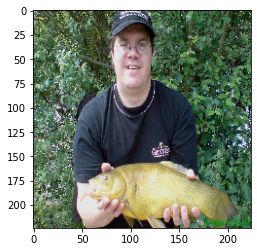


resnet18 prediction for sample 0
	#1: tench
	#2: gas pump
	#3: golf ball
	#4: chain saw
	#5: garbage truck


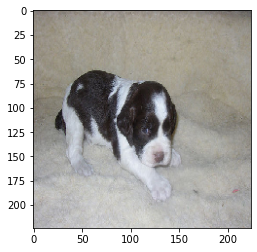


resnet18 prediction for sample 0
	#1: golf ball
	#2: parachute
	#3: English springer
	#4: chain saw
	#5: cassette player


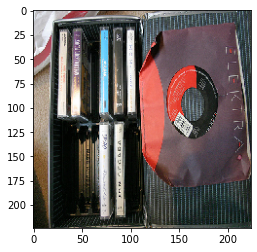


resnet18 prediction for sample 0
	#1: gas pump
	#2: French horn
	#3: chain saw
	#4: cassette player
	#5: church


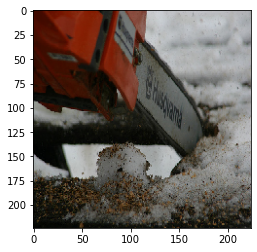


resnet18 prediction for sample 0
	#1: golf ball
	#2: chain saw
	#3: church
	#4: French horn
	#5: gas pump


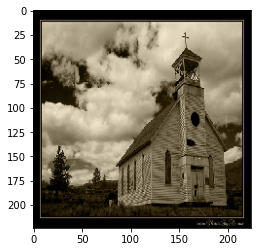


resnet18 prediction for sample 0
	#1: church
	#2: French horn
	#3: chain saw
	#4: golf ball
	#5: gas pump


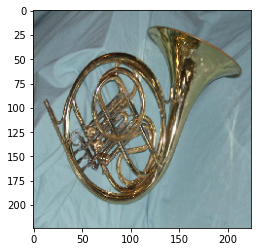


resnet18 prediction for sample 0
	#1: French horn
	#2: parachute
	#3: golf ball
	#4: gas pump
	#5: chain saw


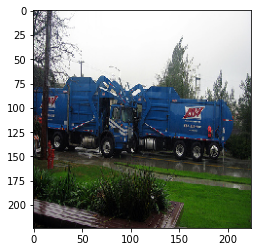


resnet18 prediction for sample 0
	#1: church
	#2: parachute
	#3: golf ball
	#4: gas pump
	#5: garbage truck


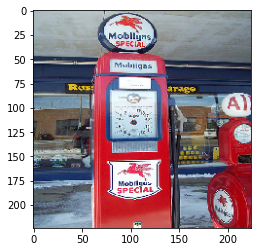


resnet18 prediction for sample 0
	#1: gas pump
	#2: parachute
	#3: cassette player
	#4: garbage truck
	#5: golf ball


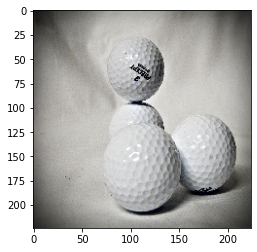


resnet18 prediction for sample 0
	#1: golf ball
	#2: parachute
	#3: church
	#4: garbage truck
	#5: chain saw


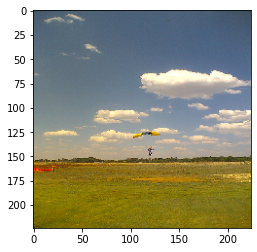


resnet18 prediction for sample 0
	#1: parachute
	#2: church
	#3: golf ball
	#4: gas pump
	#5: cassette player


In [8]:
for i in range(10):
    load_images_and_run(i)